In this code, we will evaluate the correlation between the series of protests and international oil prices and fuel subsidies. We will also compare the relationship between protests and other indicators of social pressure.

# Pearson Correlation

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
sns.set_context('talk', font_scale=.8)

workDir = r'.\Data'

protestDF = pd.read_csv(r'{}\Data\Protest\protestas_original.csv'.format(workDir), parse_dates = ['date'], index_col = 'date', delimiter = ';')
protestDF = protestDF[~protestDF.personas.isna()]
# Load Media Indicators
rsuiDF = pd.read_csv(r'{}\Data\GDELT\RSU_index.csv'.format(workDir), parse_dates = ['date'], index_col = 'date').filter(regex = 'RSUI')
acledDF = pd.read_csv(r'{}\Data\ACLED\acled_final_new.csv'.format(workDir), parse_dates = ['date'], index_col = 'date').filter(regex = 'acled')
# Merge all data
dataDF = pd.merge(protestDF, rsuiDF, left_index=True, right_index=True)
dataDF = pd.merge(dataDF, acledDF, left_index=True, right_index=True)

# Keep Relevant Columns
pearsoncorr = dataDF.corr(method='pearson')

In [3]:
pearsoncorr.filter(regex = 'RSUI').loc['personas']

RSUI_A_d    0.458052
RSUI_A_w    0.466781
RSUI_A_m    0.456946
RSUI_B_d    0.259951
RSUI_B_w    0.307020
RSUI_B_m    0.349925
Name: personas, dtype: float64

In [4]:
pearsoncorr.filter(regex = 'acled').loc['personas']

acled_d    0.653265
acled_w    0.667418
acled_m    0.670535
Name: personas, dtype: float64

Because the highest correlation is against the number of events, we will use this series for subsequent analyses.

## Rolling-Window Correlation

### GDELT

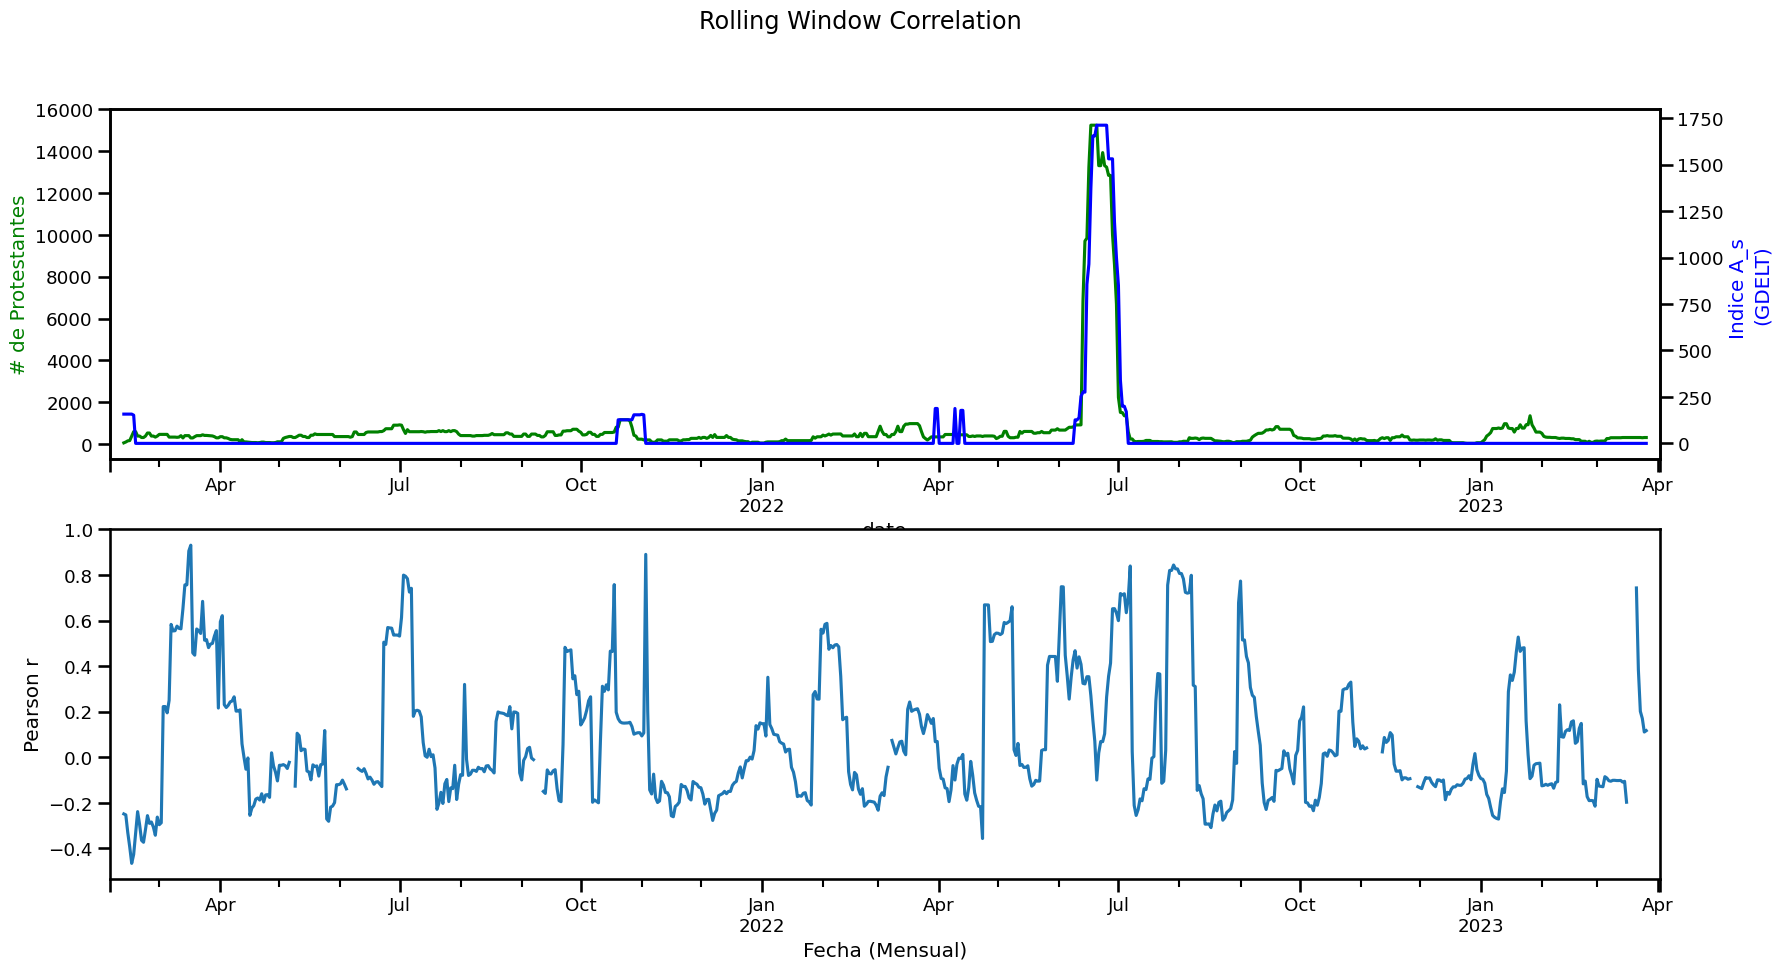

In [5]:
## Correlacion por Ventanas

# Definir tamaño del Rolling Window
r_window_size = 15

# Compute rolling window synchrony
rolling_r = dataDF['personas'].rolling(window=r_window_size, center=True).corr(dataDF['RSUI_A_w'])

# Graficar Serie de Eventos
fig, ax = plt.subplots(2, 1, figsize=(20,10))
ax2 = ax[0].twinx()
dataDF.personas.rolling(window=r_window_size, center=True).median().plot(ax = ax[0], color='g')
dataDF.RSUI_A_w.rolling(window=r_window_size, center=True).median().plot(ax = ax2, color='b')
ax[0].set_ylabel('# de Protestantes', color='g')
ax2.set_ylabel('Indice A_s \n(GDELT)', color='b')

rolling_r.plot(ax=ax[1])
ax[1].set(xlabel='Fecha (Mensual)',ylabel='Pearson r')
plt.suptitle("Rolling Window Correlation")
plt.show()


### ACLED

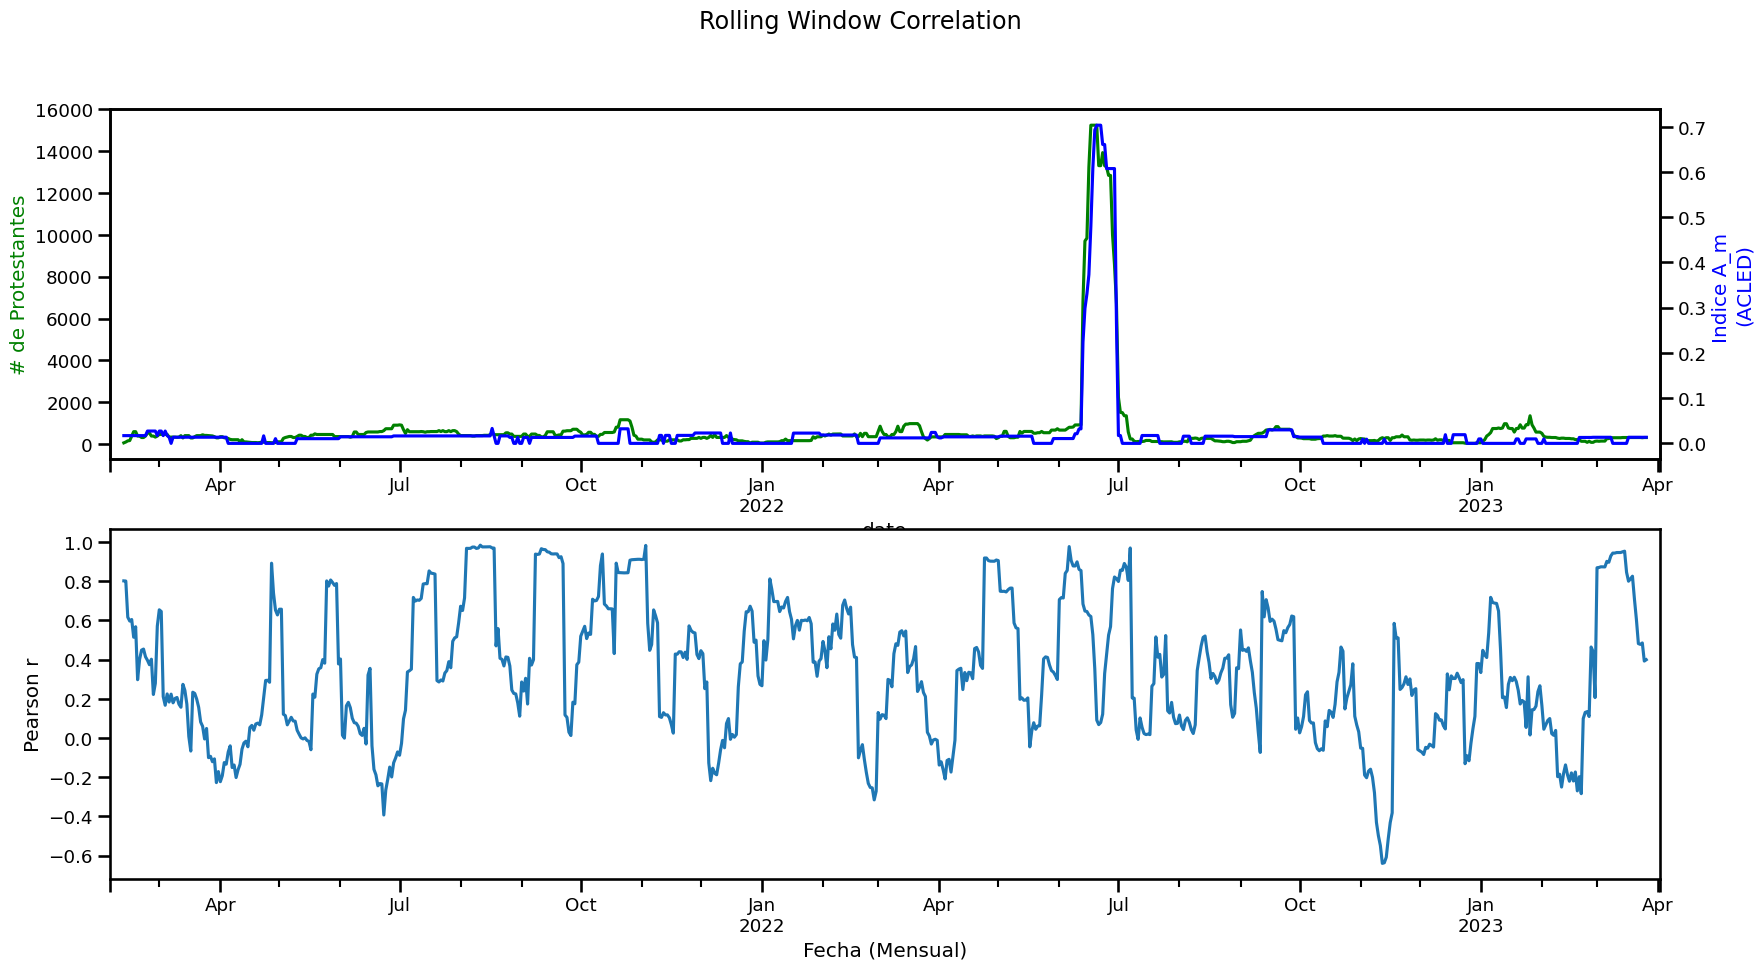

In [6]:
## Correlacion por Ventanas

# Definir tamaño del Rolling Window
r_window_size = 15

# Compute rolling window synchrony
rolling_r = dataDF['personas'].rolling(window=r_window_size, center=True).corr(dataDF['acled_m'])

# Graficar Serie de Eventos
fig, ax = plt.subplots(2, 1, figsize=(20,10))
ax2 = ax[0].twinx()
dataDF.personas.rolling(window=r_window_size, center=True).median().plot(ax = ax[0], color='g', label = 'Protestantes')
dataDF.acled_m.rolling(window=r_window_size, center=True).median().plot(ax = ax2, color='b', label = 'A_s')
ax[0].set_ylabel('# de Protestantes', color='g')
ax2.set_ylabel('Indice A_m \n(ACLED)', color='b')

rolling_r.plot(ax=ax[1])
ax[1].set(xlabel='Fecha (Mensual)',ylabel='Pearson r')
plt.suptitle("Rolling Window Correlation")
plt.show()


## Correlacion por desfaces

We will also calculate the lagged correlation between the two series to assess whether one is a leading indicator of the other and over what period this relationship is maximized. We will assess a maximum lag of 30 days, and given the nature of the variables, we will treat WTI as exogenous (i.e., we will only assess whether it is a leading indicator of protests).

In [8]:
def crosscorr(Series_X, Series_Y, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    Series_X, Series_Y : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedY = Series_Y.shift(lag)
        shiftedY.iloc[:lag] = Series_Y.iloc[-lag:].values
        return Series_X.corr(shiftedY)
    else: 
        return Series_X.corr(Series_Y.shift(lag))

### GDELT

C:\Users\Ramon\AppData\Local\Temp\ipykernel_15456\1817815655.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(i - periodo_evaluado) for i in ax.get_xticks()])


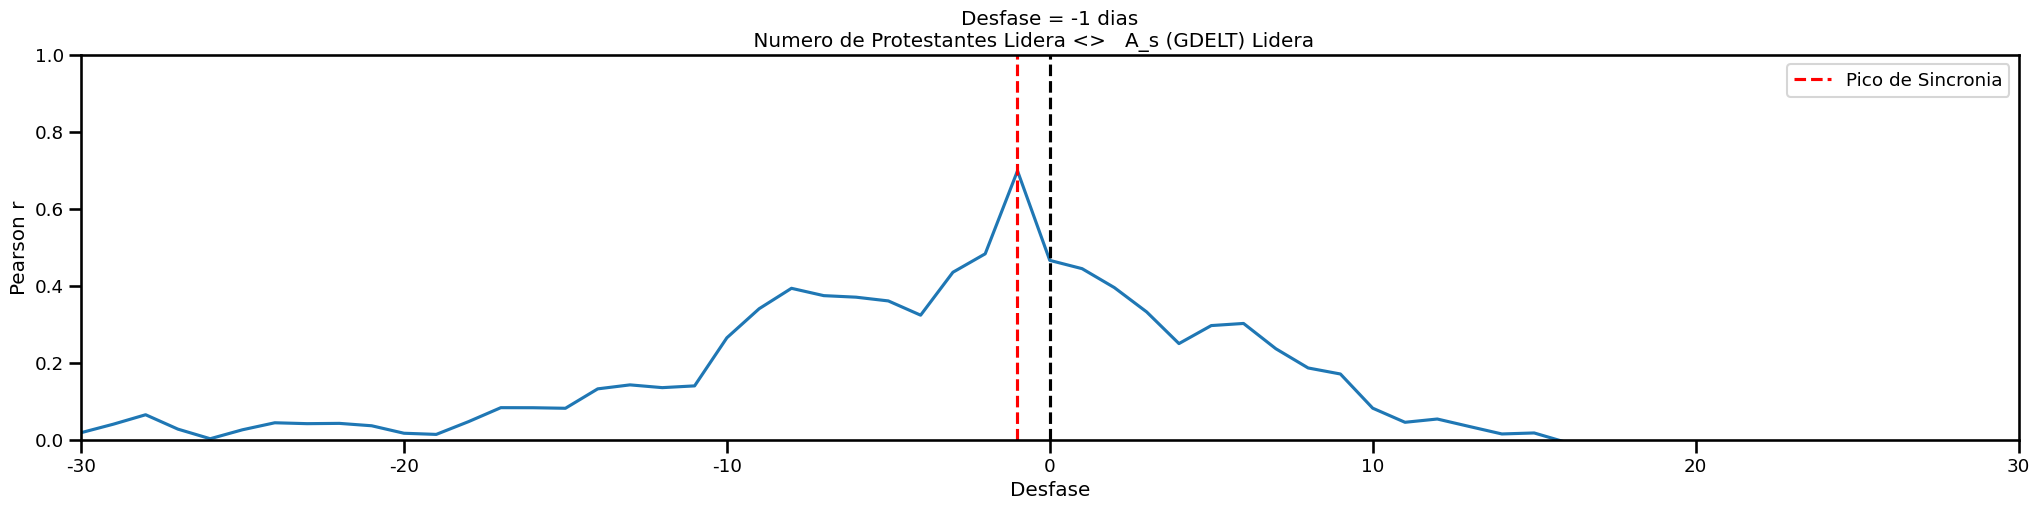

In [16]:
num_eventos = dataDF['personas']
indicador = dataDF['RSUI_A_w']
periodo_evaluado = 30

# Calculo de Correlacion Desfasada
rs = [crosscorr(num_eventos, indicador, lag) for lag in range(-periodo_evaluado, periodo_evaluado)]

offset = np.argmax(rs) - periodo_evaluado

f, ax=plt.subplots(figsize=(25, 5))
ax.plot(rs)
ax.axvline(periodo_evaluado, color='k',linestyle='--')
ax.axvline(np.argmax(rs),color='r',linestyle='--', label='Pico de Sincronia')
ax.set(title=f'Desfase = {offset} dias\n Numero de Protestantes Lidera <>   A_s (GDELT) Lidera      ',ylim=[.0,1],xlim=[0, 2 * periodo_evaluado], xlabel='Desfase',ylabel='Pearson r')
ax.set_xticklabels([int(i - periodo_evaluado) for i in ax.get_xticks()])
plt.legend()
plt.show()

### ACLED

C:\Users\Ramon\AppData\Local\Temp\ipykernel_15456\3584316339.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(i - periodo_evaluado) for i in ax.get_xticks()])


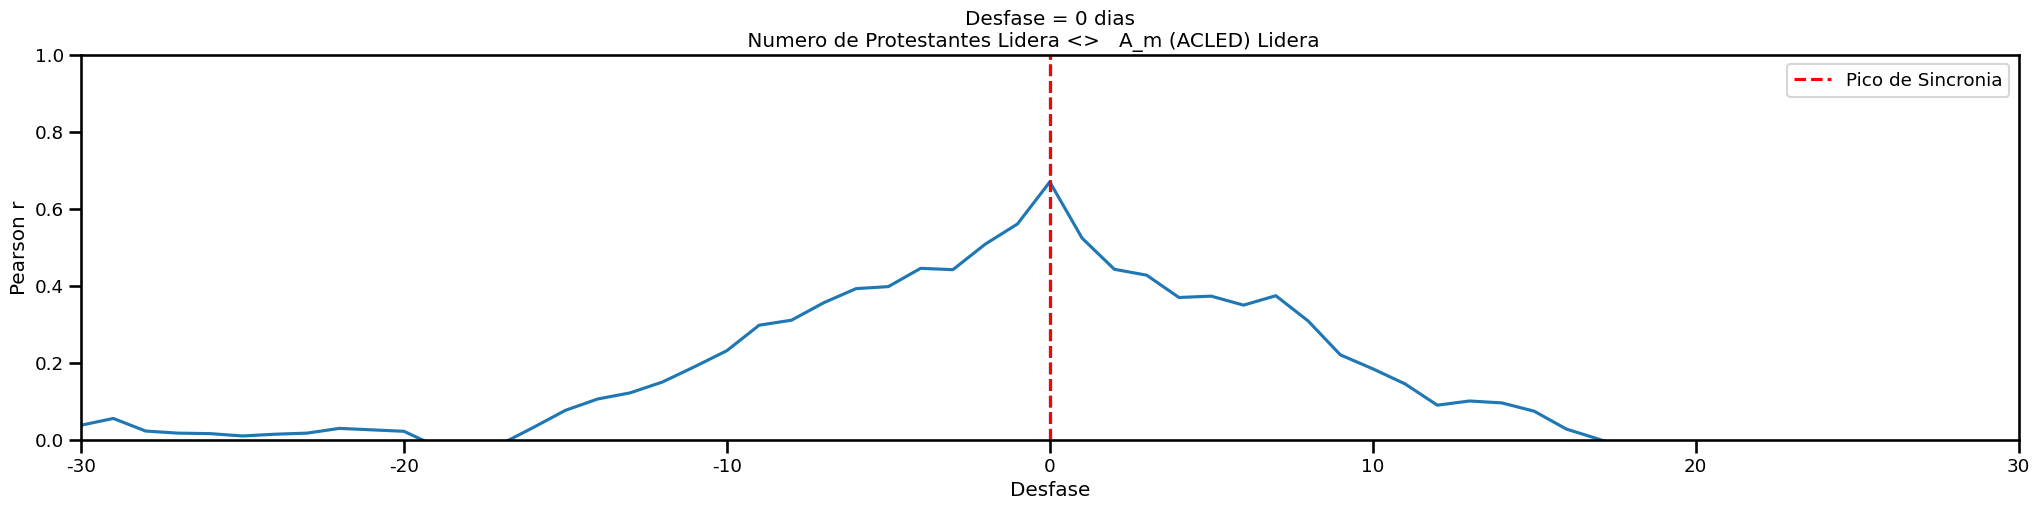

In [17]:
num_eventos = dataDF['personas']
indicador = dataDF['acled_m']
periodo_evaluado = 30

# Calculo de Correlacion Desfasada
rs = [crosscorr(num_eventos, indicador, lag) for lag in range(-periodo_evaluado, periodo_evaluado)]

offset = np.argmax(rs) - periodo_evaluado

f, ax=plt.subplots(figsize=(25, 5))
ax.plot(rs)
ax.axvline(periodo_evaluado, color='k',linestyle='--')
ax.axvline(np.argmax(rs),color='r',linestyle='--', label='Pico de Sincronia')
ax.set(title=f'Desfase = {offset} dias\n Numero de Protestantes Lidera <>   A_m (ACLED) Lidera      ',ylim=[.0,1],xlim=[0, 2 * periodo_evaluado], xlabel='Desfase',ylabel='Pearson r')
ax.set_xticklabels([int(i - periodo_evaluado) for i in ax.get_xticks()])
plt.legend()
plt.show()